<a href="https://colab.research.google.com/github/quanvu0996/TF_cert_training/blob/main/v2.5_ML20M%20optimizing%20cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import psutil
# gives a single float value
print(psutil.cpu_percent())
# gives an object with many fields
print(psutil.virtual_memory())
# you can convert that object to a dictionary print(dict(psutil.virtual_memory()._asdict()))
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

25.3
svmem(total=13617745920, available=11800350720, percent=13.3, used=1624301568, free=11029200896, active=1791774720, inactive=571740160, buffers=70541312, cached=893702144, shared=1236992, slab=137969664)
13.3
86.65231927017771


In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Libs

In [3]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import gc
import math

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow_addons.losses import TripletSemiHardLoss 
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE

In [4]:
tf.__version__

'2.8.0'

In [5]:
itemCol = 'movieId'
userCol = 'userId'

In [6]:
# DGX setup
# fpath = "./ml-20m" 

#colab setup
from google.colab import drive
drive.mount('/content/gdrive')
fpath = "/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# Loading data
ratings = pd.read_csv(fpath+'/ratings.csv')

ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


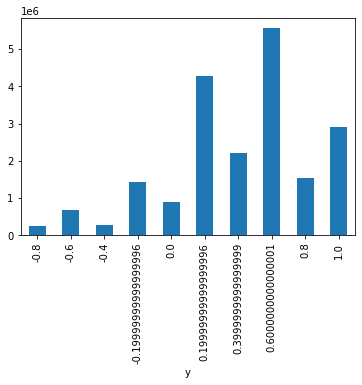

In [8]:
# Normalize rating về dạng -1 -> 1 (-1 = ghét, 1 = thích)
ratings["y"] = ratings["rating"]/2.5-1

# Kiểm tra rating trong khoảng -1 -> 1
ratings.groupby("y")["y"].count().plot(kind='bar')

In [9]:
# Loading movie
movies = pd.read_csv(fpath+'/movies.csv')
movies["year"]=movies["title"].apply(lambda x: x[-5:-1])
movies["genres"] = movies["genres"].apply(lambda x: ' ' if x == '(no genres listed)' else ' '.join(x.split('|')) )
movies["title"]= movies["title"].apply(lambda x: x[0:-7])
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji,Adventure Children Fantasy,1995
2,3,Grumpier Old Men,Comedy Romance,1995
3,4,Waiting to Exhale,Comedy Drama Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


# Model v2.3
Sử dụng constrastive loss thay cho onehot

In [10]:
# Chia dữ liệu thành các tập cho model clustering, nhãn recommendation và test
#     warm_up_mask: ratings đã quan sát
#     target: rating dùng để đánh giá kết quả recommend của module recommend cho từng người dùng
#     test: đánh giá độc lập
# TODO: chia tập dữ liệu theo user-wise => đánh giá với những user hoàn toàn mới thì model có học được không?
# v2.1. gộp warm_up và mask thành 1
def dataset_split(ratings):
    train, test = train_test_split(ratings, test_size= 0.25)
    warm_up_mask, target = train_test_split(train, test_size= 0.25)
    return warm_up_mask, target, test

warm_up_mask, target, test = dataset_split(ratings)

In [11]:
# Kiểm tra số lượng ratings
warm_up_mask.shape[0], target.shape[0], test.shape[0]

(11250147, 3750050, 5000066)

In [12]:
# v2.2: chỉ groupby, không padding
def get_interaction_set(interaction, max_item = None, top_k_item = None):
    """
    Input:
        interaction: df[userCol, itemCol, y]: dữ liệu đầu vào
        max_item: int: item num limit
    Output:
        df, itemCol: list, y: list, itemCol_str: string, userCol as index
        list item sắp xếp theo giảm dần độ lớn rating
    """
    items = ratings.groupby(itemCol).count().sort_values(by=userCol, ascending=False)
    if top_k_item is not None:
        top_items = items.head(top_k_item).index
        interaction = interaction[interaction[itemCol].isin(top_items)]
    else:
        top_items = items.index

    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = interaction.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    interaction = interaction.reindex(rindex)
    
    # Chuyển thành warm-up set theo từng user
    interaction = interaction.groupby("userId").agg({itemCol:list, "y":list})

    # Giới hạn độ dài warm_up size
    if max_item is not None:
        interaction[itemCol] = interaction[itemCol].apply(lambda x: x[0:max_item])
        interaction["y"] = interaction["y"].apply(lambda x: x[0:max_item])

    return interaction, top_items

top_k_item = 20000
wu_size = 200
mask_size = 200
max_item = wu_size + mask_size

# interac_df, top_items = get_interaction_set(warm_up_mask[warm_up_mask[userCol]<3000]
#                     , max_item = max_item
#                     , top_k_item = top_k_item )
# interac_df

# define top_items
top_items = ratings.groupby(itemCol).count().sort_values(by=userCol, ascending=False).head(top_k_item).index

In [13]:
# len(top_items)

### Class  model

In [14]:
# Khởi tạo cấu hình: xác định encoder, decoder, mapping dims
class Efficient_Rec(tf.keras.Model):
  def __init__(self, encoder, decoder= None, reps=None, use_tf_function=False):
    super().__init__()
    self.use_tf_function = use_tf_function

    self.encoder = encoder
    self.decoder = decoder
    self.reps = reps

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [15]:
def _wu_mask_split(self, batch_inputs, mask_ratio = 0.25):
    "Chia ratings và items thành mask, warm up"
    input_items, input_ratings = batch_inputs[itemCol], batch_inputs["y"]

    def list_split(input, mask_ratio = 0.25, seed= 42):
        return train_test_split(input[0:(wu_size+mask_size)], test_size= mask_ratio, random_state=seed)

    seed = random.randint(1, 100)
    items = input_items.apply(lambda x: list_split(x, mask_ratio, seed))
    ratings = input_ratings.apply(lambda x: list_split(x, mask_ratio, seed))

    wu_item_list = items.apply(lambda x: x[0])
    mask_item_list = items.apply(lambda x: x[1])

    wu_rating_list = ratings.apply(lambda x: x[0])
    mask_rating_list = ratings.apply(lambda x: x[1])
    return (wu_item_list, wu_rating_list), (mask_item_list, mask_rating_list)

Efficient_Rec._wu_mask_split = _wu_mask_split

In [16]:
def _wu_mask_split2(self, batch_inputs, mask_ratio = 0.25):
    "Chia ratings và items thành mask, warm up, giữ nguyên full set trong warmup"
    input_items, input_ratings = batch_inputs[itemCol], batch_inputs["y"]

    def list_split(input, mask_ratio = 0.25, seed= 42):
        return train_test_split(input[0:(wu_size+mask_size)], test_size= mask_ratio, random_state=seed)

    seed = random.randint(1, 100)
    items = input_items.apply(lambda x: list_split(x, mask_ratio, seed))
    ratings = input_ratings.apply(lambda x: list_split(x, mask_ratio, seed))

    wu_item_list = input_items #items.apply(lambda x: x[0])
    mask_item_list = items.apply(lambda x: x[1])

    wu_rating_list = input_ratings #ratings.apply(lambda x: x[0])
    mask_rating_list = ratings.apply(lambda x: x[1])
    return (wu_item_list, wu_rating_list), (mask_item_list, mask_rating_list)

Efficient_Rec._wu_mask_split2 = _wu_mask_split2

In [17]:
def _preprocess(self, inputs, padding_size = 100):
    """
    Padding về wu_size và mask_size, convert list of items => string of items
    batch_inputs: df: itemStr, y"""

    def padding_list(list_item, wu_size, value=0, is_padding=True):
        series_item1 = list_item[0:wu_size]
        if is_padding:
            series_item1 = series_item1+[value]*(wu_size-len(series_item1))
        return series_item1

    items_list, ratings_list = inputs

    items   = items_list.apply(lambda x: ' '.join(list([str(i) for i in x])))
    ratings =   np.stack( ratings_list.apply(lambda x: padding_list( x, padding_size  ) ) )

    return items, ratings

Efficient_Rec._preprocess = _preprocess

In [18]:
# Thực hiện training
def _train_step(self, inputs):
    warm_up, mask = self._wu_mask_split(inputs, mask_ratio = 0.25)
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, mask_size)

    with tf.GradientTape() as tape:
        # Encode the input
        wu_vec = self.encoder([wu_items, wu_ratings])
        y_pred = self.reps(wu_vec)

        # Encde the output
        mask_vec = self.decoder([mask_item, mask_ratings])

        average_loss = self.loss(mask_vec, y_pred)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._train_step = _train_step

In [19]:
# Thực hiện minibatch training
def _batch_train_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    for chunk in chunks:
        self._train_step(chunk)

Efficient_Rec._batch_train_step = _batch_train_step

In [20]:
# Thực hiện training
def _constrastive_train_step(self, inputs):
    warm_up, mask = self._wu_mask_split2(inputs.sample(frac=1), mask_ratio = 0.5)
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, wu_size)

    # negative_items = wu_items.shift(1, axis=0, fill_value=['0 '])
    negative_items = np.roll( wu_items.values, shift= 1, axis=0)
    negative_items = pd.Series(negative_items)
    negative_ratings =  np.roll( wu_ratings, shift= 1, axis=0)

    with tf.GradientTape() as tape:
        # Interaction embedding
        wu_vec = self.encoder([wu_items, wu_ratings])
        mask_vec = self.encoder([mask_item, mask_ratings])
        negative_vec = self.encoder([negative_items, negative_ratings])

        average_loss = self.loss(wu_vec, mask_vec, negative_vec) #- 0.1*np.mean([tf.linalg.norm(x) for x in self.trainable_variables])

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    gradients = [None if gradient is None else tf.clip_by_value(gradient, -0.1, 0.1)
                 for gradient in gradients]
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._constrastive_train_step = _constrastive_train_step

In [21]:
# Thực hiện minibatch training
# @tf.function
def _constrastive_train_minibatch_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    losses = []
    for chunk in chunks:
        loss = self._constrastive_train_step(chunk)
        losses.append(loss["batch_loss"].numpy())
        print(loss)
    return np.mean(losses)

Efficient_Rec._constrastive_train_minibatch_step = _constrastive_train_minibatch_step

### Xây dựng encoder model
Encoder =  interaction embedding + user feature embedding<br> 
interaction embedding = sum( interaction embedding các item i)<br> 
interaction embedding item i = rating x (embedding id sản phẩm + embedding item feature)<br>



In [22]:
%%time
# Vectorize (encode + padding) item list
max_vocab_size = len(top_items) # nếu số item có <= top_k_item => lấy số lượng item max
items_str = ' '.join([str(i) for i in top_items])
itemStr = itemCol+"_str"

vectorizer = layers.TextVectorization( max_tokens= top_k_item, split='whitespace', output_sequence_length= wu_size, name = 'vectorizer')
vectorizer.adapt( [items_str] ) 

CPU times: user 372 ms, sys: 29 ms, total: 401 ms
Wall time: 643 ms


In [23]:
class Broadcasting_Multiply(tf.keras.layers.Layer):
    """Nhân 2 layers khác shape với nhau, trong đó:
    inputs=[layer1, layer2]
    layer1.shape = (None, n_item, n_feature)
    layer2.shape = (None, n_item)
    (Chú ý đúng thứ tự)
    """

    def call(self, inputs):
        x, y = inputs
        deno = tf.expand_dims(tf.cast(tf.math.count_nonzero(y, axis=1), tf.float32), -1)
        #we add the extra dimension:
        y = K.expand_dims(y, axis=-1)
        #we replicate the elements
        y = K.repeat_elements(y, rep=x.shape[2], axis=-1)

        return x * y, deno

In [24]:
# Xây dựng mạng
embedding_size = 173
reps_size = 132
cluster_num = 43

@tf.function
def avg_layer(z):
    t = K.sum(z[0], axis=1)/z[1]
    t = tf.clip_by_value( t, -1, 1 )
    t = tf.where(tf.math.is_nan(t), tf.zeros_like(t), t)
    return t


def interaction_embedding2():

    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim= max_vocab_size, output_dim= embedding_size, mask_zero= True, name='ei')(wi)
    # wi = layers.Dense(embedding_size, activation='sigmoid', use_bias = False, name='di')(wi)
    wi = layers.Dense(embedding_size, activation='relu', use_bias = False, name='di1')(wi)
    wi = layers.Dense(embedding_size, activation='relu', use_bias = False, name='di2')(wi)
    # wi = layers.Dense(embedding_size, activation='sigmoid', use_bias = False, name='di3')(wi)

    wr = layers.Input(shape=(wu_size,), name='warm_up_ratings')

    ireps = Broadcasting_Multiply(name='mul')([wi, wr])
    uprofile = layers.Lambda(lambda z: avg_layer(z) )(ireps)

    uprofile = layers.Dense( reps_size, activation='relu', name='du1')(uprofile)
    uprofile = layers.Dense( reps_size, activation='relu', name='du2')(uprofile)
    # uprofile = layers.Dense( reps_size, activation='relu', name='du3')(uprofile)
    # uprofile = layers.BatchNormalization(name='norm')(uprofile)
    uprofile = layers.LayerNormalization(name='norm')(uprofile)
    # uprofile = layers.Dense( reps_size, activation='relu', name='du4')(uprofile)
    uprofile = layers.Dense(cluster_num, activation='sigmoid', name='clustering')(uprofile)
    
    
    model = tf.keras.Model(inputs= [input_wi, wr], outputs=[uprofile])
    return model

In [25]:
# Example of layer interaction embedding step by step
# input_wi = ["15 25 65 20 84",  # 5 items
#             "51 54 45 21 24 83 81 76 74 75 72 48 29 38",# 14 items
#             " ",] 

# tvectorizer = layers.TextVectorization( max_tokens= 17, split='whitespace', output_sequence_length= 10)
# tvectorizer.adapt( input_wi ) 

# wi = tvectorizer(input_wi)
# print(wi)
# wi = layers.Embedding(input_dim= 17, output_dim= 4, mask_zero= True, name='ei')(wi)
# print(wi)
# wi = layers.Dense(3, activation='sigmoid',  use_bias = False, name='di')(wi)

# wr = np.array([[0.5, 0.1, -0.5, 1, 0.25, 0, 0, 0, 0, 0], [0.25, 0.15, 0.5, 1, 0.25, 0.5, 0.1, -0.9, 0.4, -0.3], [0,0,0,0,0,0,0,0,0,0]])

# ireps = Broadcasting_Multiply(name='mul')([wi, wr])
# print(ireps)
# uprofile = layers.Lambda(lambda z: avg_layer(z) )(ireps)
# print(uprofile)

# uprofile = layers.Dense( reps_size, activation='relu', name='du2')(uprofile)
# uprofile = layers.LayerNormalization(name='norm')(uprofile)
# uprofile = layers.Dense(5, activation='sigmoid', name='clustering')(uprofile)
# print(uprofile)

In [26]:
# Kiểm tra tham số
# interaction_embedding2().summary()

In [27]:
# tf.keras.utils.plot_model( interaction_embedding2() ,show_shapes=True, show_dtype=True, show_layer_names=True )

# Evaluate model results

In [75]:
def model_evaluate(model, movies, df):
    dfu, ttop_items = get_interaction_set( df
                    , max_item = max_item
                    , top_k_item = top_k_item )
    group_scores = model.encoder(model._preprocess( [dfu[itemCol], dfu["y"]], padding_size = wu_size )).numpy()

    print("SAMPLE INTERACTION EMBEDDING")
    print( np.max(group_scores), np.mean(group_scores), np.min(group_scores) )
    print( group_scores[0:3] )

    print("FEATURE PLOT")
    feature_plot( movies, df, group_scores)
    
    print("CLUSTER CHECKING")
    check_cluster(group_scores)
    
    print("SPECTROGRAM PLOT")
    plot_spectrogram(group_scores)

def get_label(movies, df, is_encode = False):
    movies["genres_list"] = movies["genres"].apply(lambda x: x.split(' '))
    movie_genres = movies.explode("genres_list")
    gr = df.merge(movie_genres, on="movieId").groupby(["userId", "genres_list"])["movieId"].count().reset_index()
    gr["rank"] = gr.groupby("userId")["movieId"].rank(method='first', ascending=False)

    labels = gr[gr["rank"] ==1].set_index("userId")
    # labels["pred_max_ind"] = np.argmax(group_scores, axis=1)

    if is_encode:
        label_enc = LabelEncoder()
        labels["label"] = label_enc.fit_transform(labels["genres_list"])

    return labels

def feature_plot( movies, df, group_scores ):
    tlabels = get_label(movies, df)

    tsne = PCA(n_components=2, random_state=123)
    # tsne = TSNE(n_components=2, random_state=123)
    z = tsne.fit_transform(group_scores) 

    df = pd.DataFrame()
    df["y"] = tlabels["genres_list"]
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]

    plt.rcParams["figure.figsize"] = (8,8)
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette="Paired" ,#sns.color_palette("hls", 3),
                    data=df)#.set(title="Iris data T-SNE projection") 
    plt.show()

def check_cluster(group_scores):
    # Kiểm tra số user trong mỗi cụm có bị vón cục
    ugs= np.argmax(group_scores, axis=1)
    for i in range(50):
        print(i,': ', np.sum(ugs==i) )

def plot_spectrogram(group_scores):
    # Sort theo user_group + draw sigmoid/softmax layer
    plt.rcParams["figure.figsize"] = (10,10)
    k =100
    a = group_scores
    ind = np.argmax(group_scores, axis=1)
    plt.imshow( a[np.argsort(ind)][0:k] )
    plt.show()


In [76]:
def model_plot(model, movies, df):
    dfu, ttop_items = get_interaction_set( df
                    , max_item = max_item
                    , top_k_item = top_k_item )
    group_scores = model.encoder(model._preprocess( [dfu[itemCol], dfu["y"]], padding_size = wu_size )).numpy()
    print("FEATURE PLOT")
    feature_plot( movies, df, group_scores)
    

# Warm start user

In [30]:
u_train_from = 0
u_train_to = u_train_from+100000
u_test = u_train_to+ 5000

def get_labeled_data(df):
    interact_df, _ = get_interaction_set( 
                     df
                    , max_item = max_item
                    , top_k_item = top_k_item )
    labels = get_label( movies, df, is_encode = True)   
    interact_df["label"] = labels["label"]
    return interact_df[["movieId","y","label"]]

# if exists, do not rerun
train =  get_labeled_data( warm_up_mask[(warm_up_mask[userCol]>u_train_from)&(warm_up_mask[userCol]<u_train_to)] )
train["rating_num"] = train.apply(lambda x: len(x["y"]), axis=1)
# pretrain with warm start user
train_warm = train[train["rating_num"]>=100]

# train =  get_labeled_data( warm_up_mask[(warm_up_mask[userCol]>u_train_from)&(warm_up_mask[userCol]<u_train_to)] )
train_warm.count()

movieId       21922
y             21922
label         21922
rating_num    21922
dtype: int64

In [31]:
gc.collect()

50

# Constrastive model

In [32]:
def cossim(a, b):
    def l2(a):
        return tf.sqrt( tf.reduce_sum(tf.square(a), axis=1) )
    return tf.reduce_sum(tf.multiply(a, b), axis=1)/(l2(a)*l2(b))
    
def constrastive_loss(margin=0.01):
    def compute_loss(wu_vec, mask_vec, negative_vec):
        ap_distance = tf.linalg.norm(wu_vec - mask_vec, axis=1)
        an_distance = tf.linalg.norm(wu_vec - negative_vec, axis=1)
        # ap_distance = 1-cossim(wu_vec , mask_vec)
        # an_distance = 1-cossim(wu_vec , negative_vec)
        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        # ap_distance = tf.reduce_sum(tf.square(wu_vec - mask_vec), 1)
        # an_distance = tf.reduce_sum(tf.square(wu_vec - negative_vec), 1)
        loss = ap_distance - an_distance
        # print(loss)
        loss = tf.maximum(loss + margin, 0.)
        # tf.print(loss)
        loss = tf.reduce_mean(loss)
        return loss
    return compute_loss

def circle_loss(margin=0.01, gama=0.05):
    def compute_loss(wu_vec, mask_vec, negative_vec):
        sp = cossim(wu_vec , mask_vec)
        sn = cossim(wu_vec , negative_vec)

        loss = gama*tf.math.exp(sn - sp + margin, 0)
        # loss = tf.math.log(1+ loss)
        loss = tf.reduce_mean(loss)

        return loss
    return compute_loss

def nce_loss(t=0.5):
    def compute_loss(wu_vec, mask_vec, negative_vec):
        sp = cossim(wu_vec , mask_vec)/t
        sn = cossim(wu_vec , negative_vec)/t
        loss = - tf.math.log( sp/(sp+sn) )
        loss = tf.reduce_sum(loss)
        return loss
    return compute_loss


# Compile model
# model = Efficient_Rec( encoder = interaction_embedding2(), 
#                       reps = None, #get_reps_model(),
#                       decoder = None ,# mask_label(),
#                       use_tf_function=False)

# # Configure the loss and optimizer
# model.compile(
#     optimizer=tf.optimizers.Adam(),
#     loss= nce_loss(0.5)#constrastive_loss(margin= 1),
# )

In [33]:
%%time
# epochs= 5
# test_user =warm_up_mask[warm_up_mask[userCol]<5000]#.sample(1000)
# model_plot(model, movies, 
#                test_user)
# for n in range(epochs):
#   print(n, "/", epochs, ": ", model._constrastive_train_minibatch_step( train_warm.sample(n=5000), batch_size=512))
#   model_plot(model, movies, 
#             test_user )
#   gc.collect()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


In [34]:
# %%time
# epochs= 20
# for n in range(epochs):
#   print(n, "/", epochs, ": ", model._constrastive_train_minibatch_step( interac_df, batch_size = 520 ))
# gc.collect()

In [35]:
# model.layers[0].layers

In [36]:
# np.expand_dims(np.roll(interac_df["movieId"].apply(lambda x:' '.join([str(i) for i in x])), 1), -1)

Evaluate

In [37]:
# Kiểm tra giá trị đầu ra
# sample = warm_up_mask[(warm_up_mask[userCol]<6000) & ((warm_up_mask[userCol]>3000))]
# tinterac_df, ttop_items = get_interaction_set(warm_up_mask[warm_up_mask[userCol]<3000]
#                     , max_item = max_item
#                     , top_k_item = top_k_item )

# group_scores = model.encoder(model._preprocess( [tinterac_df[itemCol], tinterac_df["y"]], padding_size = wu_size )).numpy()
# print( np.max(group_scores), np.mean(group_scores), np.min(group_scores) )
# group_scores[0:3]

In [38]:
# movies["genres_list"] = movies["genres"].apply(lambda x: x.split(' '))
# movie_genres = movies.explode("genres_list")
# gr = sample.merge(movie_genres, on="movieId").groupby(["userId", "genres_list"])["movieId"].count().reset_index()
# gr["rank"] = gr.groupby("userId")["movieId"].rank(method='first', ascending=False)

# tlabels = gr[gr["rank"] ==1].set_index("userId")

In [39]:
# tlabels["pred_max_ind"] = np.argmax(group_scores, axis=1)

In [40]:
# tsne = TSNE(n_components=2, verbose=1, random_state=123)
# tsne = PCA(n_components=2, random_state=123)
# z = tsne.fit_transform(group_scores) 

In [41]:
# df = pd.DataFrame()
# df["y"] = tlabels["genres_list"]
# df["comp-1"] = z[:,0]
# df["comp-2"] = z[:,1]

In [42]:
# plt.rcParams["figure.figsize"] = (8,8)
# sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
#                 palette="Paired" ,#sns.color_palette("hls", 3),
#                 data=df)#.set(title="Iris data T-SNE projection") 

In [43]:
# Kiểm tra số user trong mỗi cụm có bị vón cục
# ugs= np.argmax(group_scores, axis=1)
# for i in range(50):
#     print(i,': ', np.sum(ugs==i) )


In [44]:
# Sort theo user_group + draw sigmoid/softmax layer
# plt.rcParams["figure.figsize"] = (20,10)
# k =200
# a = group_scores
# ind = np.argmax(group_scores, axis=1)
# # plt.imshow( a[np.argsort(ind)][0:k] )

In [45]:
# np.argsort(a[1])

In [46]:
# [np.isin(np.argsort(a[1]), np.array([0,1,2]) )]

In [47]:
# Vẽ theo user_group
# user_groups = [ 32 ]
# a = group_scores
# ind = np.argmax(group_scores, axis=1)
# plt.imshow( a[ np.isin( ind, user_groups)] )

In [48]:
# Vẽ y_true của các user chung group
# y_true = model.decoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = mask_size )).numpy()
# y_true_ugrs = y_true[ np.isin( ind, user_groups)]

# for i in range(y_true_ugrs.shape[0]):
#     y_true_i = y_true_ugrs[i].reshape((50,100))
#     print( np.max(y_true_i), np.min(y_true_i), np.mean(y_true_i)  )
#     plt.imshow( y_true_i)
#     plt.show()


In [49]:
# plt.imshow(y_true[0].reshape(50, 100) )

In [50]:
# y_true[0][y_true[0]!=0]

In [51]:
# y_true = model.decoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = mask_size )).numpy()[0:15]
# for i in range(y_true.shape[0]):
#     y_true_i = y_true[i].reshape((50,100))
#     print( np.max(y_true_i), np.min(y_true_i), np.mean(y_true_i)  )
#     plt.imshow( y_true_i)
#     plt.show()

In [52]:
# for i in range(group_scores.shape[0]):
#     plt.imshow( group_scores[i].numpy().reshape((5,10)) )
#     plt.show()

In [53]:
# plt.imshow(y_true)

# supervised constrastive 

In [54]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [55]:
# Thực hiện training
# TODO: sửa lại pd shift thành np.roll
def _supervised_constrastive_train_step(self, inputs):
    items_pd, ratings_pd, labels = inputs["movieId"], inputs["y"], inputs["label"]
    items, ratings = self._preprocess((items_pd, ratings_pd), wu_size)

    with tf.GradientTape() as tape:
        # Interaction embedding
        vec = self.encoder([items, ratings])

        average_loss = self.loss(labels, vec)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    # gradients = [None if gradient is None else tf.clip_by_value(gradient, -0.1, 0.1)
    #              for gradient in gradients]
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._supervised_constrastive_train_step = _supervised_constrastive_train_step

In [56]:
# Thực hiện minibatch training
# def _spv_constrastive_train_minibatch_step(self, inputs, batch_size):
#     # df1, df2, df3 = inputs[0].copy(), inputs[1].copy(), inputs[2].copy()
#     get_copy = lambda inputs: (inputs[0].copy(), inputs[1].copy(), inputs[2].copy())
#     get_chunk_df = lambda df:[df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
#     get_chunk = lambda inputs: [get_chunk_df(df) for df in inputs]
#     copies = get_copy( inputs )
#     chunks = get_chunk(copies)

#     get_chunk_i =  lambda chunks, i: (chunk[i] for chunk in chunks)
#     losses = []
#     for i in range(math.ceil(inputs[0].shape[0]/batch_size)):
#         chunk = get_chunk_i(chunks, i)
#         loss = self._supervised_constrastive_train_step(chunk)
#         losses.append(loss["batch_loss"].numpy())
#         print(loss)
#     return np.mean(losses)

# Efficient_Rec._spv_constrastive_train_minibatch_step = _spv_constrastive_train_minibatch_step

In [57]:
# Thực hiện minibatch training
def _spv_constrastive_train_minibatch_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    losses = []
    for chunk in chunks:
        loss = self._supervised_constrastive_train_step(chunk)
        losses.append(loss["batch_loss"].numpy())
        print(loss)
        gc.collect()
    return np.mean(losses)

Efficient_Rec._spv_constrastive_train_minibatch_step = _spv_constrastive_train_minibatch_step

In [58]:
# Compile model
model = Efficient_Rec( encoder = interaction_embedding2(), 
                      reps = None, #get_reps_model(),
                      decoder = None ,# mask_label(),
                      use_tf_function=False)
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate = 0.001),
    loss= TripletSemiHardLoss()#SupervisedContrastiveLoss(temperature = 0.05),
)

In [59]:
# train["movieId"].apply(lambda x: int(len(x)/10)*10).to_frame(0).reset_index().groupby(0).count(
# ).sort_values("userId", ascending=False)

In [60]:
# start_u = 5000
# test_set = warm_up_mask[(warm_up_mask[userCol]>start_u)&(warm_up_mask[userCol]<(start_u+5000))]
# model_plot(model, movies, test_set )

In [61]:
%%time
# epochs= 5
# test_set = warm_up_mask[(warm_up_mask[userCol]>10000)&(warm_up_mask[userCol]<15000)]
# model_plot(model, movies, test_set )
# for n in range(epochs):
#   print(n, "/", epochs, ": ", model._spv_constrastive_train_minibatch_step(train_warm.sample(frac=0.1), batch_size=512))
#   model_plot(model, movies, test_set )
#   gc.collect()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


In [62]:
# model_evaluate(model, movies, 
#                warm_up_mask[warm_up_mask[userCol]<5000])

In [221]:
# model_evaluate(model, movies, 
#                warm_up_mask[(warm_up_mask[userCol]>u_train_to)&(warm_up_mask[userCol]<(u_train_to+5000))])

# Triplet loss
Triplet loss với warm up, mask lấy từ interaction cùng 1 người, negative chọn từ một người khác không cùng category

Note: chuyển note sau thành file .py

In [64]:
# WU-Mask triplet loss
import tensorflow as tf
from tensorflow_addons.losses import metric_learning
from tensorflow_addons.utils.keras_utils import LossFunctionWrapper
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from typeguard import typechecked
from typing import Optional, Union, Callable


def _masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.
    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the minimum.
    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = tf.math.reduce_max(data, dim, keepdims=True)
    masked_minimums = (
        tf.math.reduce_min(
            tf.math.multiply(data - axis_maximums, mask), dim, keepdims=True
        )
        + axis_maximums
    )
    return masked_minimums


@tf.keras.utils.register_keras_serializable(package="Addons")
@tf.function
def triplet_hard_warmup_mask_loss(
    y_true: TensorLike,
    y_pred: TensorLike,
    margin: FloatTensorLike = 1.0,
    soft: bool = False,
    distance_metric: Union[str, Callable] = "L2",
) -> tf.Tensor:
    """Computes the triplet loss with hard negative and hard positive mining.
    Args:
      y_true: 1-D integer `Tensor` with shape [batch_size] of
        multiclass integer labels.
      y_pred: 2-D float `Tensor` of embedding vectors. Embeddings should
        be l2 normalized.
      margin: Float, margin term in the loss definition.
      soft: Boolean, if set, use the soft margin version.
      distance_metric: str or function, determines distance metric:
                       "L2" for l2-norm distance
                       "squared-L2" for squared l2-norm distance
                       "angular" for cosine similarity
                        A custom function returning a 2d adjacency
                          matrix of a chosen distance metric can
                          also be passed here. e.g.
                          def custom_distance(batch):
                              batch = 1 - batch @ batch.T
                              return batch
                          triplet_semihard_loss(batch, labels,
                                        distance_metric=custom_distance
                                    )
    Returns:
      triplet_loss: float scalar with dtype of y_pred.
    """

    labels, embeddings = y_true, y_pred
    wu_embeddings, mask_embeddings = embeddings

    def convert_to_float(embeddings):
        convert_to_float32 = (
            embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
        )
        precise_wu_embeddings = (
            tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
        )
        return precise_wu_embeddings, convert_to_float32

    precise_wu_embeddings, convert_to_float32_wu = convert_to_float(wu_embeddings)
    precise_mask_embeddings, convert_to_float32_mask = convert_to_float(mask_embeddings)

    convert_to_float32 = (convert_to_float32_wu or convert_to_float32_mask)

    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    if distance_metric == "L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_wu_embeddings, squared=False
        )
        hard_positives =  metric_learning.pairwise_distance(
            precise_wu_embeddings - precise_mask_embeddings, squared=False
        )

    elif distance_metric == "squared-L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_wu_embeddings, squared=True
        )
        hard_positives =  metric_learning.pairwise_distance(
            precise_wu_embeddings - precise_mask_embeddings, squared=True
        )

    elif distance_metric == "angular":
        pdist_matrix = metric_learning.angular_distance(precise_wu_embeddings)
        hard_positives =  metric_learning.angular_distance(
            precise_wu_embeddings - precise_mask_embeddings
        )

    else:
        pdist_matrix = distance_metric(precise_wu_embeddings)
        hard_positives =  distance_metric( precise_wu_embeddings - precise_mask_embeddings )
    

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    # hard negatives: smallest D_an.
    hard_negatives = _masked_minimum(pdist_matrix, adjacency_not)

    hard_positives = tf.expand_dims(hard_positives, -1)
    

    if soft:
        triplet_loss = tf.math.log1p(tf.math.exp(hard_positives - hard_negatives))
    else:
        triplet_loss = tf.maximum(hard_positives - hard_negatives + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    if convert_to_float32:
        return tf.cast(triplet_loss, embeddings.dtype)
    else:
        return triplet_loss



@tf.keras.utils.register_keras_serializable(package="Addons")
class TripletHardWarmupMaskedLoss(LossFunctionWrapper):
    """Computes the triplet loss with hard negative and hard positive mining.
    The loss encourages the maximum positive distance (between a pair of embeddings
    with the same labels) to be smaller than the minimum negative distance plus the
    margin constant in the mini-batch.
    The loss selects the hardest positive and the hardest negative samples
    within the batch when forming the triplets for computing the loss.
    See: https://arxiv.org/pdf/1703.07737.
    We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape
    [batch_size] of multi-class integer labels. And embeddings `y_pred` must be
    2-D float `Tensor` of l2 normalized embedding vectors.
    Args:
      margin: Float, margin term in the loss definition. Default value is 1.0.
      soft: Boolean, if set, use the soft margin version. Default value is False.
      name: Optional name for the op.
    """

    @typechecked
    def __init__(
        self,
        margin: FloatTensorLike = 1.0,
        soft: bool = False,
        distance_metric: Union[str, Callable] = "L2",
        name: Optional[str] = None,
        **kwargs
    ):
        super().__init__(
            triplet_hard_warmup_mask_loss,
            name=name,
            reduction=tf.keras.losses.Reduction.NONE,
            margin=margin,
            soft=soft,
            distance_metric=distance_metric,
        )

Triplet ver1 với sửa lại với negative sample: so sánh khoảng cách của toàn bộ tương tác của người dùng ancol với negative (thay vì warm-up ancol với warm-up negative), với positive giữ nguyên (so sánh warm up và mask)

In [65]:
# WU-Mask triplet loss
import tensorflow as tf
from tensorflow_addons.losses import metric_learning
from tensorflow_addons.utils.keras_utils import LossFunctionWrapper
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from typeguard import typechecked
from typing import Optional, Union, Callable


def _masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.
    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the minimum.
    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = tf.math.reduce_max(data, dim, keepdims=True)
    masked_minimums = (
        tf.math.reduce_min(
            tf.math.multiply(data - axis_maximums, mask), dim, keepdims=True
        )
        + axis_maximums
    )
    return masked_minimums


@tf.keras.utils.register_keras_serializable(package="Addons")
@tf.function
def triplet_hard_warmup_mask_loss2(
    y_true: TensorLike,
    y_pred: TensorLike,
    margin: FloatTensorLike = 1.0,
    soft: bool = False,
    distance_metric: Union[str, Callable] = "L2",
) -> tf.Tensor:
    """Computes the triplet loss with hard negative and hard positive mining.
    Args:
      y_true: 1-D integer `Tensor` with shape [batch_size] of
        multiclass integer labels.
      y_pred: 2-D float `Tensor` of embedding vectors. Embeddings should
        be l2 normalized.
      margin: Float, margin term in the loss definition.
      soft: Boolean, if set, use the soft margin version.
      distance_metric: str or function, determines distance metric:
                       "L2" for l2-norm distance
                       "squared-L2" for squared l2-norm distance
                       "angular" for cosine similarity
                        A custom function returning a 2d adjacency
                          matrix of a chosen distance metric can
                          also be passed here. e.g.
                          def custom_distance(batch):
                              batch = 1 - batch @ batch.T
                              return batch
                          triplet_semihard_loss(batch, labels,
                                        distance_metric=custom_distance
                                    )
    Returns:
      triplet_loss: float scalar with dtype of y_pred.
    """

    labels, embeddings = y_true, y_pred
    wu_embeddings, mask_embeddings = embeddings

    def convert_to_float(embeddings):
        convert_to_float32 = (
            embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
        )
        precise_wu_embeddings = (
            tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
        )
        return precise_wu_embeddings, convert_to_float32

    precise_wu_embeddings, convert_to_float32_wu = convert_to_float(wu_embeddings)
    precise_mask_embeddings, convert_to_float32_mask = convert_to_float(mask_embeddings)
    precise_embeddings = tf.math.add(precise_wu_embeddings, precise_mask_embeddings)

    convert_to_float32 = (convert_to_float32_wu or convert_to_float32_mask)

    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    if distance_metric == "L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=False
        )
        hard_positives =  metric_learning.pairwise_distance(
            precise_wu_embeddings - precise_mask_embeddings, squared=False
        )

    elif distance_metric == "squared-L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=True
        )
        hard_positives =  metric_learning.pairwise_distance(
            precise_wu_embeddings - precise_mask_embeddings, squared=True
        )

    elif distance_metric == "angular":
        pdist_matrix = metric_learning.angular_distance(precise_embeddings)
        hard_positives =  metric_learning.angular_distance(
            precise_wu_embeddings - precise_mask_embeddings
        )

    else:
        pdist_matrix = distance_metric(precise_embeddings)
        hard_positives =  distance_metric( precise_wu_embeddings - precise_mask_embeddings )
    

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    # hard negatives: smallest D_an.
    hard_negatives = _masked_minimum(pdist_matrix, adjacency_not)

    hard_positives = tf.expand_dims(hard_positives, -1)
    

    if soft:
        triplet_loss = tf.math.log1p(tf.math.exp(hard_positives - hard_negatives))
    else:
        triplet_loss = tf.maximum(hard_positives - hard_negatives + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    if convert_to_float32:
        return tf.cast(triplet_loss, embeddings.dtype)
    else:
        return triplet_loss



@tf.keras.utils.register_keras_serializable(package="Addons")
class TripletHardWarmupMaskedLoss2(LossFunctionWrapper):
    """Computes the triplet loss with hard negative and hard positive mining.
    The loss encourages the maximum positive distance (between a pair of embeddings
    with the same labels) to be smaller than the minimum negative distance plus the
    margin constant in the mini-batch.
    The loss selects the hardest positive and the hardest negative samples
    within the batch when forming the triplets for computing the loss.
    See: https://arxiv.org/pdf/1703.07737.
    We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape
    [batch_size] of multi-class integer labels. And embeddings `y_pred` must be
    2-D float `Tensor` of l2 normalized embedding vectors.
    Args:
      margin: Float, margin term in the loss definition. Default value is 1.0.
      soft: Boolean, if set, use the soft margin version. Default value is False.
      name: Optional name for the op.
    """

    @typechecked
    def __init__(
        self,
        margin: FloatTensorLike = 1.0,
        soft: bool = False,
        distance_metric: Union[str, Callable] = "L2",
        name: Optional[str] = None,
        **kwargs
    ):
        super().__init__(
            triplet_hard_warmup_mask_loss2,
            name=name,
            reduction=tf.keras.losses.Reduction.NONE,
            margin=margin,
            soft=soft,
            distance_metric=distance_metric,
        )

In [66]:
# Thực hiện training
def _wu_mask_triplet_train_step(self, inputs):
    items_pd, ratings_pd, labels = inputs["movieId"], inputs["y"], inputs["label"]
    warm_up, mask = self._wu_mask_split2(inputs.sample(frac=1), mask_ratio = 0.5)
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, wu_size)

    with tf.GradientTape() as tape:
        # Interaction embedding
        wu_vec = self.encoder([wu_items, wu_ratings])
        mask_vec = self.encoder([mask_item, mask_ratings])

        average_loss = self.loss( labels,  (wu_vec, mask_vec)) 

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    # gradients = [None if gradient is None else tf.clip_by_value(gradient, -0.1, 0.1)
    #              for gradient in gradients]
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._wu_mask_triplet_train_step = _wu_mask_triplet_train_step

In [67]:
# Thực hiện minibatch training
def _wu_mask_triplet_train_minibatch_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    losses = []
    for chunk in chunks:
        loss = self._wu_mask_triplet_train_step(chunk)
        losses.append(loss["batch_loss"].numpy())
        print(loss)
        gc.collect()
    return np.mean(losses)

Efficient_Rec._wu_mask_triplet_train_minibatch_step = _wu_mask_triplet_train_minibatch_step

In [68]:
# Compile model
model = Efficient_Rec( encoder = interaction_embedding2(), 
                      use_tf_function=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=TripletHardWarmupMaskedLoss2())

In [220]:
%%time
epochs= 5
# test_set = warm_up_mask[(warm_up_mask[userCol]>1000)&(warm_up_mask[userCol]<2000)]
# model_plot( model, movies, test_set )
# for n in range(epochs):
#   print(n, "/", epochs, ": ", model._wu_mask_triplet_train_minibatch_step(train_warm.sample(frac=0.5), batch_size=512))
#   model_plot(model, movies, test_set )
#   gc.collect()

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.6 µs


In [70]:
gc.collect()

8178

In [195]:
# model_evaluate(model, movies, 
#                warm_up_mask[(warm_up_mask[userCol]>u_train_to)&(warm_up_mask[userCol]<(u_train_to+5000))])

# Pick item pipeline

In [196]:
interaction_list = train_warm.sample(100)
interaction_list.head()

,movieId,y,label,rating_num
userId,,,,
4831,"[2072, 318, 150, 223, 1339, 2391, 2174, 296, 1...","[1.0, 1.0, 0.8, 0.8, 0.8, 0.6000000000000001, ...",4,366
13708,"[3897, 3253, 8464, 1704, 4226, 3178, 1288, 728...","[1.0, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.600...",4,120
7173,"[2948, 1272, 8253, 3740, 541, 58559, 33794, 27...","[0.8, 0.8, 0.8, 0.8, 0.8, 0.6000000000000001, ...",0,129
79774,"[3089, 928, 7156, 27674, 26094, 6783, 5291, 25...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7,181
75841,"[2670, 69849, 3365, 927, 2243, 1201, 2762, 130...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7,400


In [197]:
scores = model.encoder(model._preprocess( [interaction_list[itemCol], interaction_list["y"]], padding_size = wu_size )).numpy()
scores

array([[0.16856453, 0.5212598 , 0.01696524, ..., 0.25227448, 0.4817343 ,
        0.13696793],
       [0.04770955, 0.80021995, 0.24182722, ..., 0.01670617, 0.22157687,
        0.03809494],
       [0.8816725 , 0.6417148 , 0.4149051 , ..., 0.7560985 , 0.44042295,
        0.6948451 ],
       ...,
       [0.23891339, 0.269067  , 0.06528461, ..., 0.2551822 , 0.22859603,
        0.18575677],
       [0.11902368, 0.02457425, 0.30251503, ..., 0.770838  , 0.75038004,
        0.6792711 ],
       [0.00984502, 0.00576821, 0.00146148, ..., 0.08169612, 0.9829749 ,
        0.14830908]], dtype=float32)

In [198]:
scores.shape

(100, 43)

In [199]:
scores[0]

array([0.16856453, 0.5212598 , 0.01696524, 0.6989819 , 0.14083174,
       0.47768027, 0.0230099 , 0.1121017 , 0.79406077, 0.97331846,
       0.89399636, 0.9529396 , 0.864697  , 0.30191153, 0.19623628,
       0.7585747 , 0.3196181 , 0.8373841 , 0.72404677, 0.861625  ,
       0.7623465 , 0.9374287 , 0.91035473, 0.18015692, 0.76768196,
       0.44919813, 0.59690684, 0.19576782, 0.852062  , 0.60185766,
       0.03021875, 0.54369277, 0.42102662, 0.7338475 , 0.11532536,
       0.25863594, 0.5692041 , 0.02702314, 0.04115716, 0.73601997,
       0.25227448, 0.4817343 , 0.13696793], dtype=float32)

In [200]:
np.argmax(scores, axis=-1)

array([ 9, 21, 11, 33, 29,  4, 25, 40, 25, 41, 28, 25,  9, 25,  9, 25, 41,
       12, 41, 33,  8, 33, 16, 25,  8, 18, 24, 21, 25, 33, 21, 14, 25,  8,
       41, 12,  7, 20, 23, 12, 12, 40, 41, 40, 24, 24,  8, 25, 24,  8, 41,
       32, 29, 18, 19,  4,  7, 25, 34, 24, 21, 12,  9, 25, 25, 12, 41, 12,
       17, 40, 12, 11, 12, 24,  8,  4,  4, 41, 33, 24, 24, 12, 25, 33, 41,
       12, 32, 41, 22, 24,  9, 12,  9, 15, 21, 17,  4,  9, 29,  8])

In [201]:
idx = np.argsort(-scores.transpose(),axis=0)[:4]
idx

array([[ 9, 21, 11, 33, 29,  4, 25, 40, 25, 41, 28, 25,  9, 25,  9, 25,
        41, 12, 41, 33,  8, 33, 16, 25,  8, 18, 24, 21, 25, 33, 21, 14,
        25,  8, 41, 12,  7, 20, 23, 12, 12, 40, 41, 40, 24, 24,  8, 25,
        24,  8, 41, 32, 29, 18, 19,  4,  7, 25, 34, 24, 21, 12,  9, 25,
        25, 12, 41, 12, 17, 40, 12, 11, 12, 24,  8,  4,  4, 41, 33, 24,
        24, 12, 25, 33, 41, 12, 32, 41, 22, 24,  9, 12,  9, 15, 21, 17,
         4,  9, 29,  8],
       [11, 35, 33, 13,  8, 25, 23, 31, 24, 12,  8, 28, 18, 23, 41,  2,
        26, 18, 33, 13, 36, 19, 18, 24, 35,  9, 15, 10,  4, 41,  9,  2,
         4,  9, 12, 18, 35,  4, 25, 28, 18, 24, 29, 24, 19, 34, 41, 24,
         9, 18, 33, 33, 25, 17, 24, 25, 10,  9,  8, 25, 10, 28, 26,  9,
         2, 28, 42, 31, 23, 19, 18, 20, 39, 25, 32, 18, 16,  9,  7, 31,
        31, 39,  4, 41, 20, 10, 20, 12, 33, 33, 18, 31, 29, 22, 33, 21,
        18, 25, 24,  9],
       [21, 39,  0, 32,  9, 23, 24, 19, 20,  8, 23,  4, 22, 17, 33, 23,
        20, 24

In [202]:
scores[0][idx.transpose()[0]]

array([0.97331846, 0.9529396 , 0.9374287 , 0.91035473], dtype=float32)

In [204]:
interaction_list["clusters"] = [list(i) for i in idx.transpose()]

In [205]:
interaction_list["scores"] = [ list(scores[i][ind]) for i, ind in enumerate(idx.transpose()) ]

In [206]:
interaction_list.head()

,movieId,y,label,rating_num,clusters,scores
userId,,,,,,
4831,"[2072, 318, 150, 223, 1339, 2391, 2174, 296, 1...","[1.0, 1.0, 0.8, 0.8, 0.8, 0.6000000000000001, ...",4,366,"[9, 11, 21, 22]","[0.97331846, 0.9529396, 0.9374287, 0.91035473]"
13708,"[3897, 3253, 8464, 1704, 4226, 3178, 1288, 728...","[1.0, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.600...",4,120,"[21, 35, 39, 17]","[0.98536634, 0.98002195, 0.97324693, 0.9684623]"
7173,"[2948, 1272, 8253, 3740, 541, 58559, 33794, 27...","[0.8, 0.8, 0.8, 0.8, 0.8, 0.6000000000000001, ...",0,129,"[11, 33, 0, 15]","[0.995579, 0.89375967, 0.8816725, 0.86726135]"
79774,"[3089, 928, 7156, 27674, 26094, 6783, 5291, 25...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7,181,"[33, 13, 32, 24]","[0.9911082, 0.9417604, 0.93854505, 0.93575454]"
75841,"[2670, 69849, 3365, 927, 2243, 1201, 2762, 130...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7,400,"[29, 8, 9, 24]","[0.9953228, 0.9939847, 0.98847294, 0.9884155]"


In [207]:
ratings_ = ratings.copy().set_index("userId")

In [208]:
ratings_ = ratings_.join(interaction_list, rsuffix="_l", how = "inner")

In [209]:
ratings_ = ratings_.explode(["clusters", "scores"])
ratings_["contribute_score"] = ratings_["scores"].astype("float64")*ratings_["y"]
# .groupby(["clusters", "movieId"])

In [213]:
ratings_ = ratings_.groupby(["clusters", "movieId"]).agg({
    "contribute_score":"mean"#, "contribute_score":"count"
}).reset_index()

In [214]:
ratings_.head()

,clusters,movieId,contribute_score
0,0,1,0.578984
1,0,10,0.529004
2,0,11,0.176335
3,0,13,-0.176335
4,0,17,0.385989


In [215]:
ratings_["rank"] = ratings_.groupby("clusters")["contribute_score"].rank(method='first', ascending=False)

In [219]:
ratings_[ratings_["clusters"]==0].sort_values(by="rank")

,clusters,movieId,contribute_score,rank
83,0,903,0.964973,1.0
85,0,908,0.964973,2.0
87,0,910,0.964973,3.0
92,0,916,0.964973,4.0
98,0,930,0.964973,5.0
...,...,...,...,...
598,0,7649,-0.771978,638.0
603,0,7810,-0.771978,639.0
604,0,7811,-0.771978,640.0
605,0,7812,-0.771978,641.0


# END

In [212]:
gc.collect()

355